In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from etl.util import prepare_dataset_without_leakage
from ml_features.features import prepare_features
from ml_features.customer_features import create_customer_features
from ml_features.sequence_features  import create_sequence_features
from ml_features.brand_features import create_brand_features
from ml_features.model_features import create_model_features
from ml_training.train_rf import train_rf
from ml_evaluation.dashboard import model_evaluation_report

import warnings
warnings.filterwarnings('ignore')

# Load original clean quote data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])

print(f"\n📊 Original quote data: {len(df_quotes):,} quotes from {df_quotes['numero_compte'].nunique():,} customers")


print("\n" + "="*80)
print("STRATEGY: CREATE MEANINGFUL SEQUENCE FEATURES")
print("="*80)

# 1. Enhanced customer features
customer_df = create_customer_features(df_quotes)
print(len(customer_df))

# 2. Sequence features (for multi-quote customers)
sequence_df = create_sequence_features(df_quotes)
print(len(sequence_df))


📊 Original quote data: 34,014 quotes from 23,888 customers

STRATEGY: CREATE MEANINGFUL SEQUENCE FEATURES
Creating enhanced customer features...
  Total customers: 23,888
✓ Created features for 23,888 customers
✓ New features: ['numero_compte', 'total_quotes', 'converted', 'avg_days_between_quotes', 'std_days_between_quotes', 'max_days_between_quotes', 'engagement_density', 'price_trajectory', 'unique_product_families', 'product_consistency']...
23888
Creating sequence features (this may take a moment)...
  Total customers: 23,888
✓ Created features for 23,888 customers
✓ New features: ['numero_compte', 'total_quotes', 'converted', 'avg_days_since_first_quote', 'std_days_since_first_quote', 'max_days_since_first_quote', 'avg_recent_quote_count', 'std_recent_quote_count', 'avg_recent_avg_price', 'std_recent_avg_price']...
23888


In [2]:
new_df_ = create_brand_features(df_quotes)
new_df = create_model_features(df_quotes)

new_df = pd.merge(
    new_df, 
    new_df_, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')
print(len(new_df))

CREATING BRAND INTELLIGENCE FEATURES
Processing brand data for 23,888 customers
Total quotes with brand info: 33,380
Unique brands in dataset: 93

✅ Created 12 brand intelligence features
   Samples: 23,888

📊 BRAND FEATURES SUMMARY:
--------------------------------------------------
brand_data_available           : mean=0.983, std=0.131
brand_loyalty_index            : mean=0.908, std=0.215
brand_switches                 : mean=0.179, std=0.454
prefers_premium_brand          : mean=0.253, std=0.435
prefers_budget_brand           : mean=0.294, std=0.456
prefers_top_10_brand           : mean=0.783, std=0.412
top_brand_share                : mean=0.908, std=0.215
brand_exploration_score        : mean=0.133, std=0.324
market_share_weighted_brand_score : mean=0.089, std=0.063
brand_consistency              : mean=0.828, std=0.377
... and 2 more features
CREATING MODEL COMPLEXITY & SPECIALIZATION FEATURES
Processing model data for 23,888 customers
Total quotes with model info: 33,991
Unique

Columns: ['numero_compte', 'avg_days_since_first_quote', 'std_days_since_first_quote', 'max_days_since_first_quote', 'avg_recent_quote_count', 'std_recent_quote_count', 'avg_recent_avg_price', 'std_recent_avg_price', 'avg_recent_price_std', 'std_recent_price_std', 'avg_recent_product_variety', 'std_recent_product_variety', 'avg_recent_conversion_rate', 'std_recent_conversion_rate', 'avg_current_price', 'std_current_price', 'sequence_quote_ratio', 'price_trend', 'conversion_rate_trend', 'total_quotes', 'converted', 'avg_days_between_quotes', 'std_days_between_quotes', 'max_days_between_quotes', 'engagement_density', 'price_trajectory', 'unique_product_families', 'product_consistency', 'avg_price', 'price_range', 'price_volatility', 'main_agency', 'main_region', 'avg_discount_pct']

🔧 ENCODING & PREPARING FOR MODELING...
  Preparing Customer Features...
  Features: 14, Samples: 23888

🔧 ENCODING & PREPARING FOR MODELING...
  Preparing Sequence Features...
  Features: 32, Samples: 23888



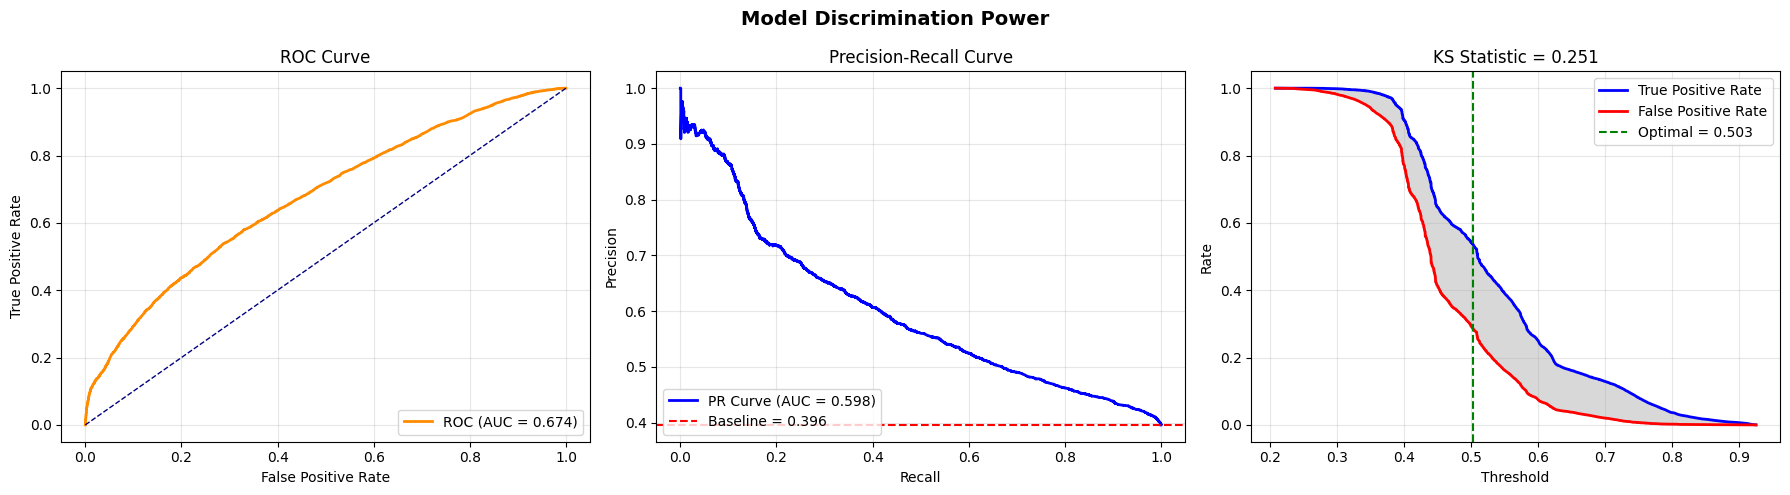

• ROC-AUC: 0.6744
• PR-AUC: 0.5980
• KS Statistic: 0.251 (WEAK discrimination)
• Optimal Threshold: 0.503

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.731
Decile 10 mean prob: 0.349


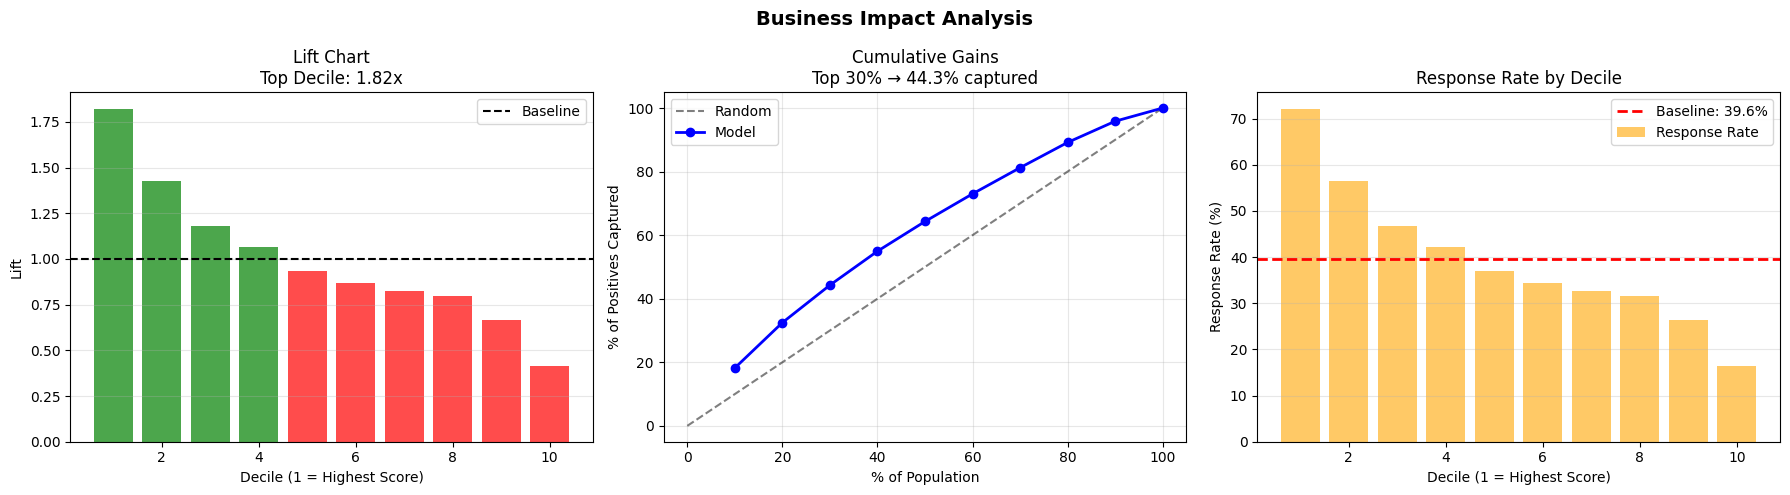

• Top Decile Lift: 0.42x
• Top 30% captures: 44.3% of positives
• Baseline response rate: 39.6%
• Top decile response: 72.1%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


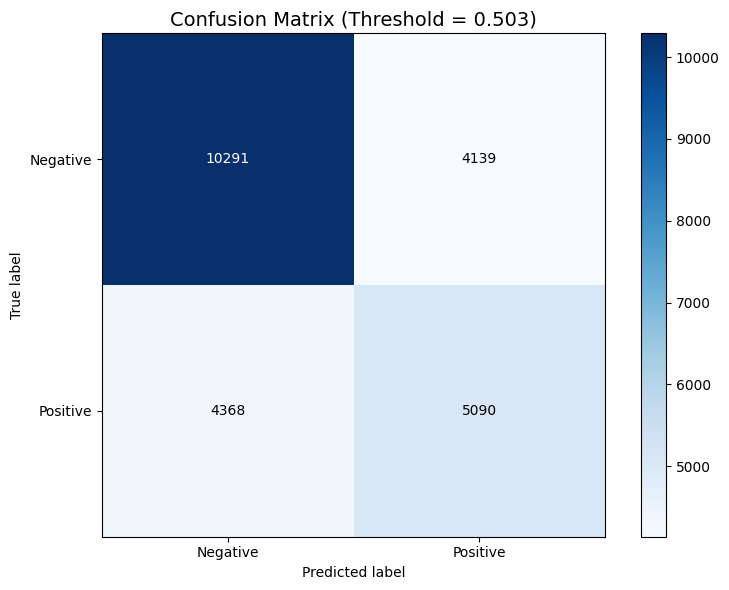

At threshold 0.503:
• Accuracy: 0.644
• Precision: 0.552
• Recall: 0.538
• F1-Score: 0.545
• True Positives: 5090
• False Positives: 4139
• True Negatives: 10291
• False Negatives: 4368

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.251 (WEAK discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.42x better than random
   Coverage: Top 30% → 44.3% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.6744 (Excellent if >0.8)
   PR-AUC: 0.5980 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.503
   Precision at threshold: 0.552
   Recall at threshold: 0.538

🧪 TEST 2: SEQUENCE FEATURES (Advanced)
✓ Model saved: sequence_prediction_model.pkl
✓ AUC: 0.677
COMPLETE MODEL VALIDATION PACKAGE

📊 STEP 1: DISCRIMINATION POWER
----------------------------------------


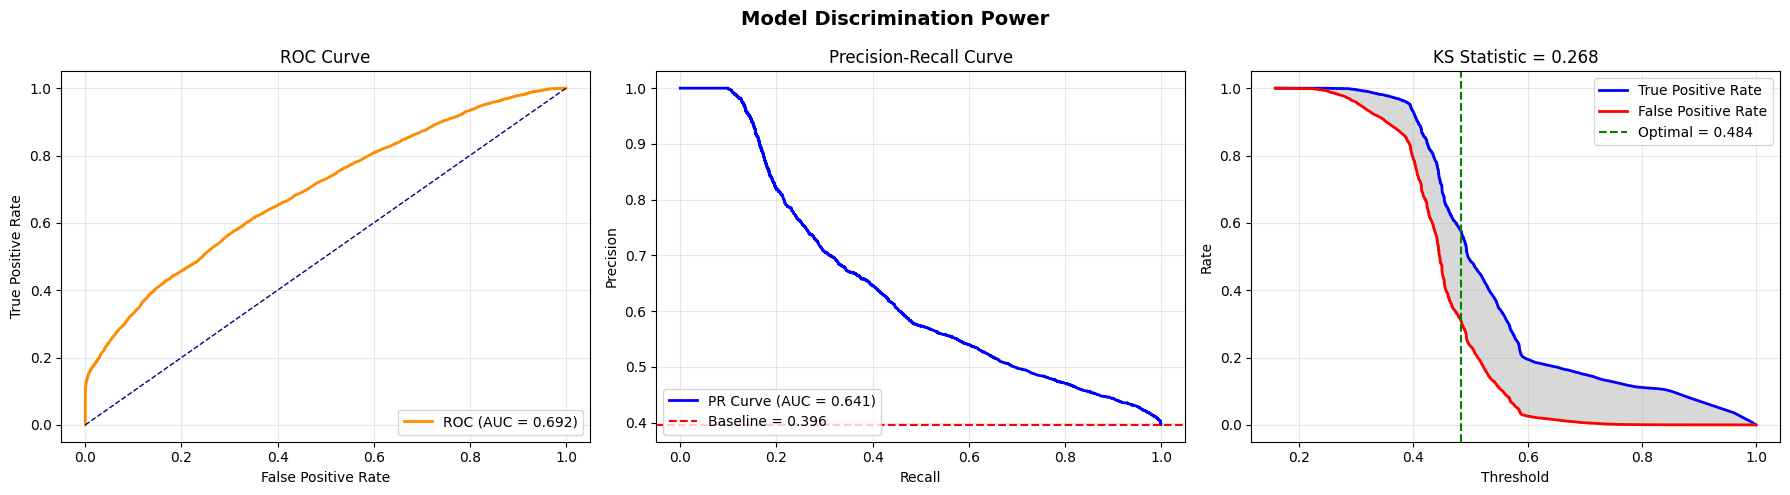

• ROC-AUC: 0.6919
• PR-AUC: 0.6412
• KS Statistic: 0.268 (WEAK discrimination)
• Optimal Threshold: 0.484

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.782
Decile 10 mean prob: 0.324


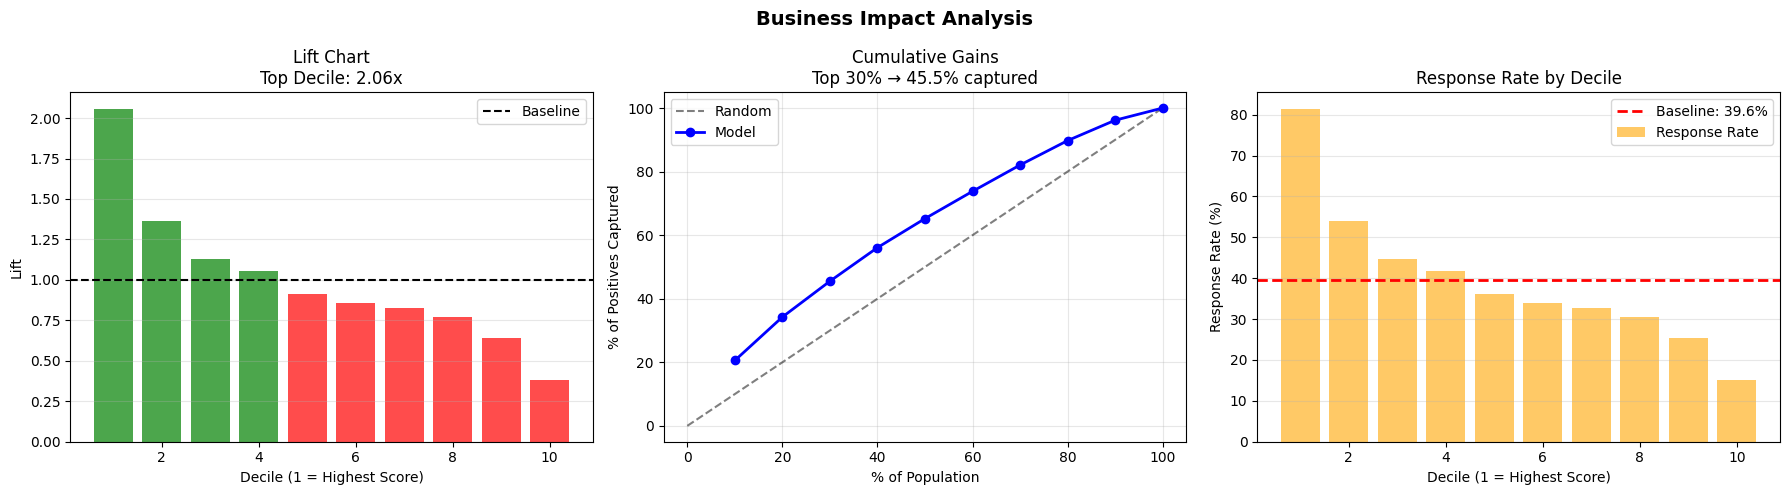

• Top Decile Lift: 0.38x
• Top 30% captures: 45.5% of positives
• Baseline response rate: 39.6%
• Top decile response: 81.5%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


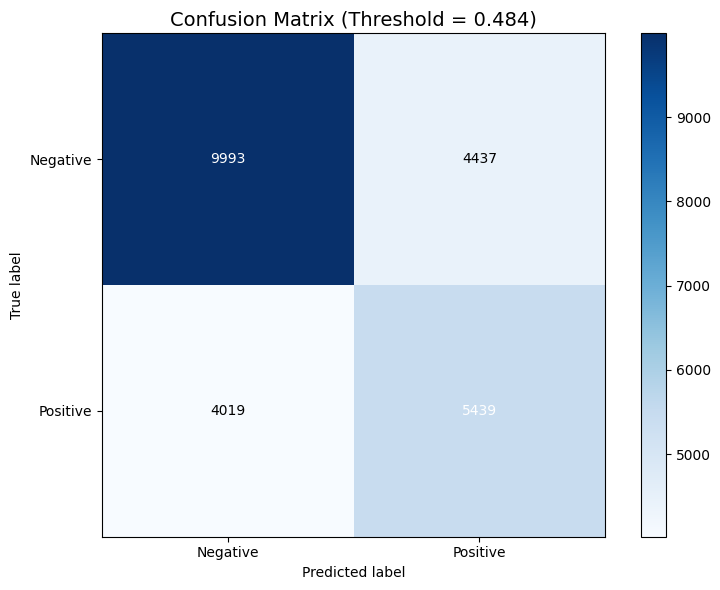

At threshold 0.484:
• Accuracy: 0.646
• Precision: 0.551
• Recall: 0.575
• F1-Score: 0.563
• True Positives: 5439
• False Positives: 4437
• True Negatives: 9993
• False Negatives: 4019

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.268 (WEAK discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.38x better than random
   Coverage: Top 30% → 45.5% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.6919 (Excellent if >0.8)
   PR-AUC: 0.6412 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.484
   Precision at threshold: 0.551
   Recall at threshold: 0.575

🧪 TEST 3: NEW FEATURES (Advanced)
✓ Model saved: sequence_prediction_model.pkl
✓ AUC: 0.690
COMPLETE MODEL VALIDATION PACKAGE

📊 STEP 1: DISCRIMINATION POWER
----------------------------------------


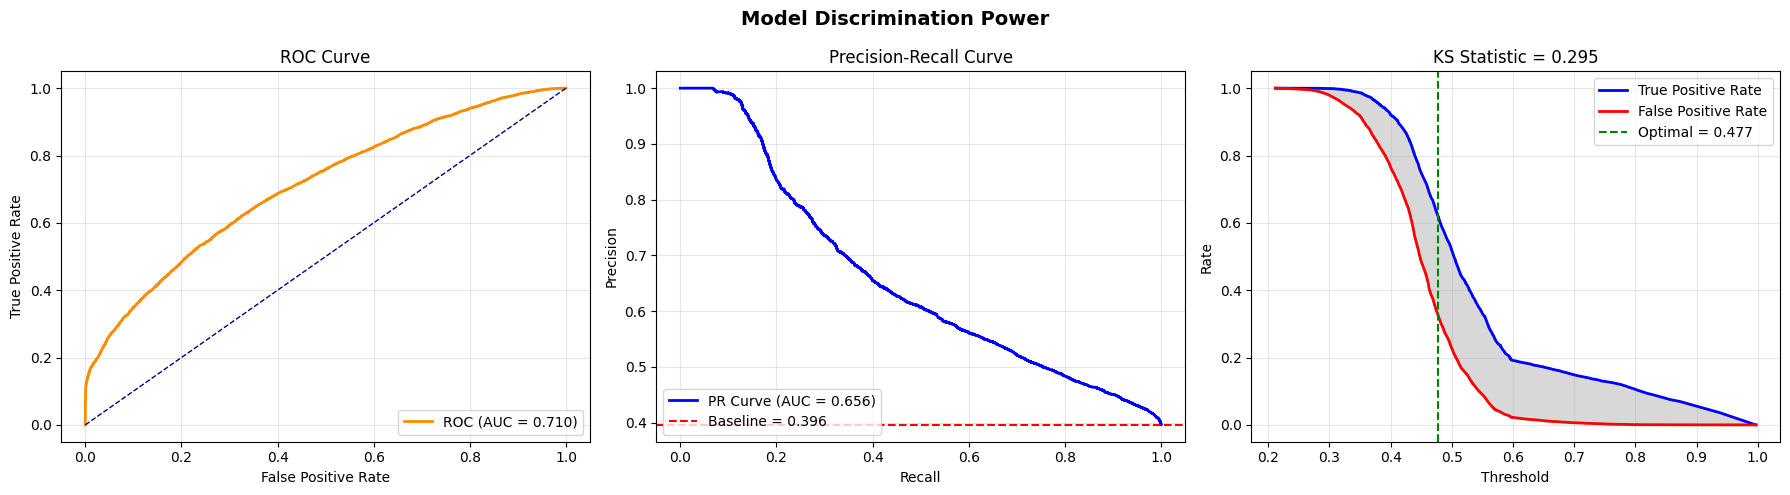

• ROC-AUC: 0.7096
• PR-AUC: 0.6563
• KS Statistic: 0.295 (WEAK discrimination)
• Optimal Threshold: 0.477

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.771
Decile 10 mean prob: 0.336


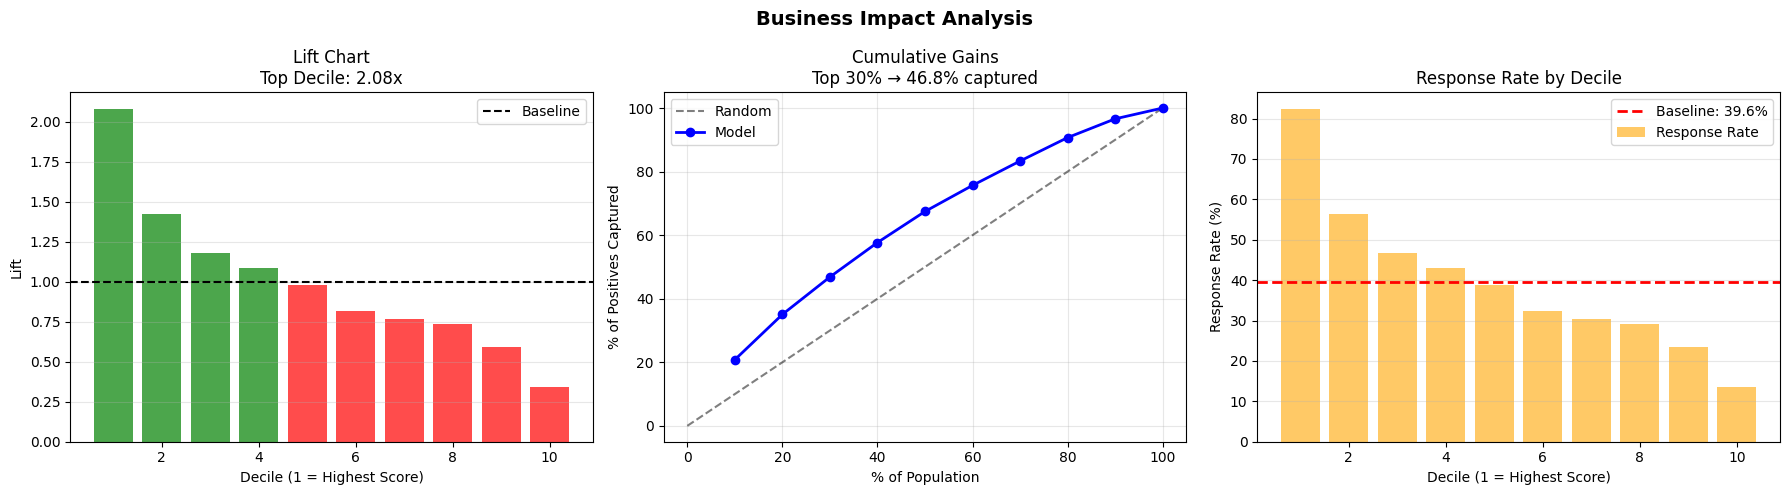

• Top Decile Lift: 0.34x
• Top 30% captures: 46.8% of positives
• Baseline response rate: 39.6%
• Top decile response: 82.4%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


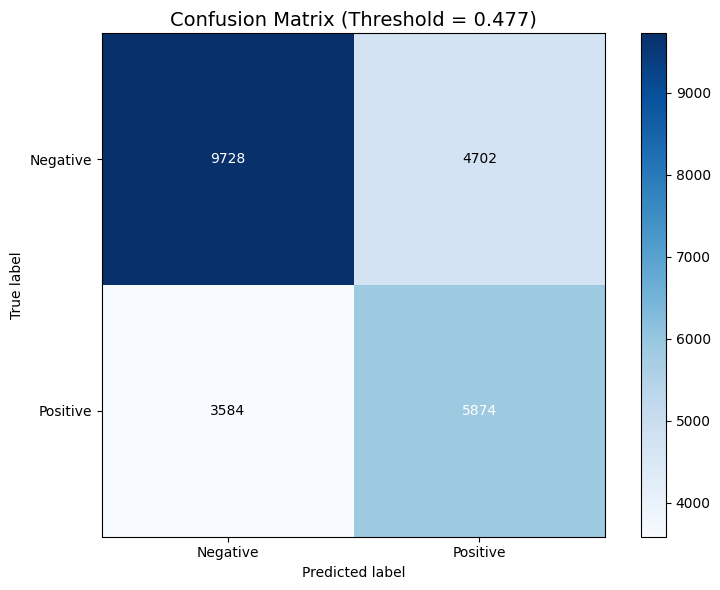

At threshold 0.477:
• Accuracy: 0.653
• Precision: 0.555
• Recall: 0.621
• F1-Score: 0.586
• True Positives: 5874
• False Positives: 4702
• True Negatives: 9728
• False Negatives: 3584

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.295 (WEAK discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.34x better than random
   Coverage: Top 30% → 46.8% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.7096 (Excellent if >0.8)
   PR-AUC: 0.6563 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.477
   Precision at threshold: 0.555
   Recall at threshold: 0.621


{'y_true': array([0., 0., 1., ..., 0., 0., 0.], shape=(23888,)),
 'y_pred_proba': array([0.51540403, 0.3999373 , 0.41210679, ..., 0.45681819, 0.33219303,
        0.42525228], shape=(23888,)),
 'y_pred': array([1, 0, 0, ..., 0, 0, 0], shape=(23888,)),
 'roc_auc': 0.70960598023402,
 'pr_auc': 0.6563207151065923,
 'ks_statistic': np.float64(0.2952126093593635),
 'optimal_threshold': np.float64(0.4773870925012376),
 'top_decile_lift': np.float64(0.3393668078148765),
 'decile_stats':    decile  count  positives  mean_prob  response_rate      lift  \
 0       1   2389     1969.0   0.770769       0.824194  2.081661   
 1       2   2389     1347.0   0.563934       0.563834  1.424072   
 2       3   2389     1115.0   0.525979       0.466722  1.178797   
 3       4   2388     1024.0   0.498240       0.428811  1.083044   
 4       5   2389      925.0   0.476236       0.387191  0.977926   
 5       6   2389      776.0   0.457755       0.324822  0.820401   
 6       7   2388      725.0   0.440609  

In [3]:
sequence_df = pd.merge(
    sequence_df, 
    customer_df, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in sequence_df.columns if '_dup' in x]
sequence_df = sequence_df.drop(columns=columns_to_drop, errors='ignore')


new_df = pd.merge(
    new_df,
    sequence_df, 
    on='numero_compte', 
    how='left',
    suffixes=('_dup', '')  # Explicit suffixes
)

columns_to_drop =  [x for x in new_df.columns if '_dup' in x]
new_df = new_df.drop(columns=columns_to_drop, errors='ignore')



print("Columns:", sequence_df.columns.tolist())

# Now it's clear which column is which
y_new = new_df['converted']  # From sequence features
y_sequence = sequence_df['converted']  # From sequence features
y_customer = customer_df['converted']  # From customer features

# For modeling, use the sequence version
X_customer = customer_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_customer_clean, y_customer_clean = prepare_features(X_customer, y_customer, "Customer Features")


X_sequence = sequence_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_sequence_clean, y_sequence_clean = prepare_features(X_sequence, y_sequence, "Sequence Features")


X_new = new_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_new_clean, y_new_clean = prepare_features(X_new, y_new, "New Features")





print("\n" + "="*80)
print("TESTING FEATURE IMPROVEMENT")
print("="*80)

# Test 1: Customer features only (baseline)
print("\n🧪 TEST 1: ENHANCED CUSTOMER FEATURES (Baseline)")
result = train_rf(X_customer_clean, y_customer_clean, 'improved_customer_model')
df = X_customer_clean.copy()
df['converted'] = y_customer_clean
model_evaluation_report(df, result['model'], result['features'], 'converted')

# Test 2: Sequence features (if available)
print("\n🧪 TEST 2: SEQUENCE FEATURES (Advanced)")
result = train_rf(X_sequence_clean, y_sequence_clean, 'sequence_prediction_model')
df = X_sequence_clean.copy()
df['converted'] = y_sequence_clean
model_evaluation_report(df, result['model'], result['features'], 'converted')


# Test 3: New features 
print("\n🧪 TEST 3: NEW FEATURES (Advanced)")
result = train_rf(X_new_clean, y_new_clean, 'sequence_prediction_model')
df = X_new_clean.copy()
df['converted'] = y_new_clean
model_evaluation_report(df, result['model'], result['features'], 'converted')

In [4]:
X_sequence_clean.columns

Index(['avg_days_since_first_quote', 'std_days_since_first_quote',
       'max_days_since_first_quote', 'avg_recent_quote_count',
       'std_recent_quote_count', 'avg_recent_avg_price',
       'std_recent_avg_price', 'avg_recent_price_std', 'std_recent_price_std',
       'avg_recent_product_variety', 'std_recent_product_variety',
       'avg_recent_conversion_rate', 'std_recent_conversion_rate',
       'avg_current_price', 'std_current_price', 'sequence_quote_ratio',
       'price_trend', 'conversion_rate_trend', 'total_quotes',
       'avg_days_between_quotes', 'std_days_between_quotes',
       'max_days_between_quotes', 'engagement_density', 'price_trajectory',
       'unique_product_families', 'product_consistency', 'avg_price',
       'price_range', 'price_volatility', 'main_agency', 'main_region',
       'avg_discount_pct'],
      dtype='object')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def diagnose_removed_customers(prev_file, new_file):
    """
    Comprehensive diagnosis of what changed between dataset versions
    """
    print("=" * 100)
    print("COMPREHENSIVE CUSTOMER REMOVAL ANALYSIS")
    print("=" * 100)
    
    # Load both datasets
    df_prev = pd.read_csv(prev_file)
    df_new = pd.read_csv(new_file)
    
    # Ensure we have the key columns
    df_prev['dt_creation_devis'] = pd.to_datetime(df_prev['dt_creation_devis'])
    df_new['dt_creation_devis'] = pd.to_datetime(df_new['dt_creation_devis'])
    
    print(f"Previous dataset: {len(df_prev):,} quotes from {df_prev['numero_compte'].nunique():,} customers")
    print(f"New dataset: {len(df_new):,} quotes from {df_new['numero_compte'].nunique():,} customers")
    print(f"Customers removed: {df_prev['numero_compte'].nunique() - df_new['numero_compte'].nunique():,}")
    print(f"Quotes removed: {len(df_prev) - len(df_new):,}")
    
    # Identify removed and added customers
    prev_customers = set(df_prev['numero_compte'].unique())
    new_customers = set(df_new['numero_compte'].unique())
    
    removed_customers = prev_customers - new_customers
    added_customers = new_customers - prev_customers
    
    print(f"\n1. CUSTOMER CHANGES:")
    print(f"   Removed customers: {len(removed_customers):,}")
    print(f"   Added customers: {len(added_customers):,}")
    print(f"   Common customers: {len(prev_customers & new_customers):,}")
    
    # Get data for removed customers
    df_removed = df_prev[df_prev['numero_compte'].isin(removed_customers)].copy()
    df_kept = df_prev[df_prev['numero_compte'].isin(prev_customers & new_customers)].copy()
    df_added = df_new[df_new['numero_compte'].isin(added_customers)].copy()
    
    # ANALYSIS 1: BASIC CHARACTERISTICS
    print(f"\n{'='*50}")
    print("ANALYSIS 1: BASIC CUSTOMER CHARACTERISTICS")
    print('='*50)
    
    def analyze_customer_group(df, group_name):
        """Analyze a group of customers"""
        if len(df) == 0:
            print(f"\n{group_name}: No data")
            return {}
        
        # Customer-level stats
        customer_stats = df.groupby('numero_compte').agg({
            'numero_compte': 'count',
            'fg_devis_accepte': 'max',
            'mt_apres_remise_ht_devis': 'mean',
            'dt_creation_devis': ['min', 'max']
        }).reset_index()
        
        customer_stats.columns = ['numero_compte', 'total_quotes', 'converted', 
                                  'avg_price', 'first_quote_date', 'last_quote_date']
        
        # Calculate tenure
        customer_stats['tenure_days'] = (customer_stats['last_quote_date'] - 
                                        customer_stats['first_quote_date']).dt.days
        
        stats = {
            'count': len(customer_stats),
            'avg_quotes': customer_stats['total_quotes'].mean(),
            'conversion_rate': customer_stats['converted'].mean(),
            'avg_price': customer_stats['avg_price'].mean(),
            'avg_tenure': customer_stats['tenure_days'].mean(),
            'single_quote_pct': (customer_stats['total_quotes'] == 1).mean() * 100
        }
        
        print(f"\n{group_name}:")
        print(f"  • Customers: {stats['count']:,}")
        print(f"  • Avg quotes per customer: {stats['avg_quotes']:.2f}")
        print(f"  • Conversion rate: {stats['conversion_rate']:.2%}")
        print(f"  • Avg quote price: €{stats['avg_price']:,.0f}")
        print(f"  • Avg tenure (days): {stats['avg_tenure']:.0f}")
        print(f"  • Single-quote customers: {stats['single_quote_pct']:.1f}%")
        
        return stats
    
    # Analyze all groups
    removed_stats = analyze_customer_group(df_removed, "REMOVED CUSTOMERS")
    kept_stats = analyze_customer_group(df_kept, "RETAINED CUSTOMERS")
    added_stats = analyze_customer_group(df_added, "NEWLY ADDED CUSTOMERS")
    
    # ANALYSIS 2: TEMPORAL PATTERNS
    print(f"\n{'='*50}")
    print("ANALYSIS 2: TEMPORAL PATTERNS")
    print('='*50)
    
    def analyze_temporal_patterns(df, group_name):
        """Analyze when these customers were active"""
        if len(df) == 0:
            return
        
        df['quote_year_month'] = df['dt_creation_devis'].dt.to_period('M')
        monthly_counts = df.groupby('quote_year_month').agg({
            'numero_compte': 'nunique',
            'fg_devis_accepte': 'mean'
        }).reset_index()
        
        monthly_counts.columns = ['period', 'unique_customers', 'conversion_rate']
        
        print(f"\n{group_name} - Temporal patterns:")
        print(f"  • First quote date: {df['dt_creation_devis'].min().date()}")
        print(f"  • Last quote date: {df['dt_creation_devis'].max().date()}")
        print(f"  • Peak month: {monthly_counts.loc[monthly_counts['unique_customers'].idxmax(), 'period']}")
        
        # Recent vs historical
        cutoff_date = pd.Timestamp('2024-06-01')  # Adjust based on your data
        recent_mask = df['dt_creation_devis'] >= cutoff_date
        
        if recent_mask.any():
            recent_pct = recent_mask.mean() * 100
            print(f"  • Quotes in last 6 months: {recent_pct:.1f}%")
    
    analyze_temporal_patterns(df_removed, "Removed customers")
    analyze_temporal_patterns(df_kept, "Retained customers")
    analyze_temporal_patterns(df_added, "Added customers")
    
    # ANALYSIS 3: PRODUCT & COMMERCIAL PATTERNS
    print(f"\n{'='*50}")
    print("ANALYSIS 3: PRODUCT & COMMERCIAL CHARACTERISTICS")
    print('='*50)
    
    def analyze_product_commercial(df, group_name):
        """Analyze what products and commercial patterns"""
        if len(df) == 0:
            return
        
        print(f"\n{group_name}:")
        
        # Product family (use new column if available, otherwise old)
        product_col = 'regroup_famille_equipement_produit' if 'regroup_famille_equipement_produit' in df.columns else 'famille_equipement_produit'
        if product_col in df.columns:
            top_products = df[product_col].value_counts().head(3)
            print(f"  Top 3 equipment types:")
            for product, count in top_products.items():
                pct = count / len(df) * 100
                print(f"    • {product}: {pct:.1f}%")
        
        # Brands if available
        if 'marque_produit' in df.columns:
            top_brands = df['marque_produit'].value_counts().head(3)
            print(f"  Top 3 brands:")
            for brand, count in top_brands.items():
                pct = count / len(df) * 100
                print(f"    • {brand}: {pct:.1f}%")
        
        # Commercial function if available
        if 'fonction_commercial' in df.columns:
            top_funcs = df['fonction_commercial'].value_counts().head(3)
            print(f"  Top 3 commercial functions:")
            for func, count in top_funcs.items():
                pct = count / len(df) * 100
                print(f"    • {func}: {pct:.1f}%")
    
    analyze_product_commercial(df_removed, "Removed customers")
    analyze_product_commercial(df_kept, "Retained customers")
    analyze_product_commercial(df_added, "Added customers")
    
    # ANALYSIS 4: CONVERSION PATTERNS
    print(f"\n{'='*50}")
    print("ANALYSIS 4: CONVERSION BEHAVIOR ANALYSIS")
    print('='*50)
    
    def analyze_conversion_patterns(df, group_name):
        """Analyze how conversion happens in this group"""
        if len(df) == 0:
            return
        
        # Conversion by quote position
        df = df.sort_values(['numero_compte', 'dt_creation_devis']).copy()
        df['quote_rank'] = df.groupby('numero_compte').cumcount() + 1
        
        # What quote position converts?
        conversion_by_position = df.groupby('quote_rank')['fg_devis_accepte'].agg(['mean', 'count']).reset_index()
        conversion_by_position.columns = ['quote_position', 'conversion_rate', 'count']
        
        first_quote_conversion = conversion_by_position[conversion_by_position['quote_position'] == 1]['conversion_rate'].values
        if len(first_quote_conversion) > 0:
            print(f"\n{group_name}:")
            print(f"  • First quote conversion rate: {first_quote_conversion[0]:.2%}")
        
        # Time to conversion for converters
        converters = df[df['fg_devis_accepte'] == 1]
        if len(converters) > 0:
            # Get first conversion date for each customer
            first_conversion = converters.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
            first_conversion.columns = ['numero_compte', 'first_conversion_date']
            
            # Merge with first quote date
            first_quote = df.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
            first_quote.columns = ['numero_compte', 'first_quote_date']
            
            conversion_timing = pd.merge(first_conversion, first_quote, on='numero_compte')
            conversion_timing['days_to_convert'] = (conversion_timing['first_conversion_date'] - 
                                                   conversion_timing['first_quote_date']).dt.days
            
            if len(conversion_timing) > 0:
                print(f"  • Avg days to convert: {conversion_timing['days_to_convert'].mean():.0f} days")
    
    analyze_conversion_patterns(df_removed, "Removed customers")
    analyze_conversion_patterns(df_kept, "Retained customers")
    analyze_conversion_patterns(df_added, "Added customers")
    
    # ANALYSIS 5: NEW FEATURES ANALYSIS (Critical for new dataset)
    print(f"\n{'='*50}")
    print("ANALYSIS 5: NEW DATASET FEATURES COMPARISON")
    print('='*50)
    
    # Check which new features are available
    new_features = ['statut_client', 'marque_produit', 'regroup_famille_equipement_produit',
                    'fonction_commercial', 'fg_nouveau_process_relance_devis', 'dt_prem_devis']
    
    available_features = [f for f in new_features if f in df_new.columns]
    print(f"New features available in v3: {available_features}")
    
    # Compare feature distributions between removed and kept customers
    if 'statut_client' in df_removed.columns:
        print(f"\nCLIENT STATUS DISTRIBUTION:")
        
        for group_name, group_df in [("Removed", df_removed), ("Retained", df_kept), ("Added", df_added)]:
            if len(group_df) > 0 and 'statut_client' in group_df.columns:
                status_dist = group_df['statut_client'].value_counts(normalize=True)
                print(f"\n{group_name} customers:")
                for status, pct in status_dist.items():
                    print(f"  • {status}: {pct:.1%}")
    
    if 'fg_nouveau_process_relance_devis' in df_removed.columns:
        print(f"\nNEW PROCESS ADOPTION:")
        
        for group_name, group_df in [("Removed", df_removed), ("Retained", df_kept), ("Added", df_added)]:
            if len(group_df) > 0 and 'fg_nouveau_process_relance_devis' in group_df.columns:
                process_usage = group_df['fg_nouveau_process_relance_devis'].mean()
                print(f"  {group_name}: {process_usage:.1%} use new process")
    
    # ANALYSIS 6: PREDICTIVE POWER ANALYSIS
    print(f"\n{'='*50}")
    print("ANALYSIS 6: PREDICTIVE POWER OF REMOVED VS RETAINED")
    print('='*50)
    
    # Create simple features to see predictive patterns
    def create_diagnostic_features(df):
        """Create features to understand predictive patterns"""
        if len(df) == 0:
            return pd.DataFrame()
        
        features = []
        
        for customer_id, customer_data in df.groupby('numero_compte'):
            f = {'customer_id': customer_id}
            
            # Basic features
            f['total_quotes'] = len(customer_data)
            f['converted'] = customer_data['fg_devis_accepte'].max()
            f['avg_price'] = customer_data['mt_apres_remise_ht_devis'].mean()
            
            # Temporal
            if len(customer_data) > 1:
                time_span = (customer_data['dt_creation_devis'].max() - 
                            customer_data['dt_creation_devis'].min()).days + 1
                f['engagement_density'] = len(customer_data) / time_span
            else:
                f['engagement_density'] = 1
            
            # Product variety
            product_col = 'regroup_famille_equipement_produit' if 'regroup_famille_equipement_produit' in customer_data.columns else 'famille_equipement_produit'
            if product_col in customer_data.columns:
                f['product_variety'] = customer_data[product_col].nunique()
            
            features.append(f)
        
        return pd.DataFrame(features)
    
    # Create features for each group
    removed_features = create_diagnostic_features(df_removed)
    kept_features = create_diagnostic_features(df_kept)
    
    if len(removed_features) > 0 and len(kept_features) > 0:
        print("\nFEATURE COMPARISON (Mean values):")
        print("\nFeature                | Removed | Retained | Difference")
        print("-" * 55)
        
        for feature in ['total_quotes', 'converted', 'avg_price', 'engagement_density']:
            if feature in removed_features.columns and feature in kept_features.columns:
                removed_mean = removed_features[feature].mean()
                kept_mean = kept_features[feature].mean()
                diff = removed_mean - kept_mean
                print(f"{feature:20} | {removed_mean:7.2f} | {kept_mean:8.2f} | {diff:+.3f}")
    
    # ANALYSIS 7: BUSINESS IMPACT ANALYSIS
    print(f"\n{'='*50}")
    print("ANALYSIS 7: BUSINESS IMPACT OF CUSTOMER REMOVAL")
    print('='*50)
    
    # Estimate business impact
    if len(df_removed) > 0:
        # Potential lost revenue
        avg_quote_value = df_removed['mt_apres_remise_ht_devis'].mean()
        conversion_rate = df_removed['fg_devis_accepte'].mean()
        potential_customers = len(removed_customers)
        
        print(f"\nPOTENTIAL BUSINESS IMPACT:")
        print(f"• Customers removed: {potential_customers:,}")
        print(f"• Avg quote value: €{avg_quote_value:,.0f}")
        print(f"• Conversion rate: {conversion_rate:.1%}")
        print(f"• Estimated lost revenue opportunity: €{potential_customers * avg_quote_value * conversion_rate:,.0f}")
        
        # Compare with retained
        avg_quote_kept = df_kept['mt_apres_remise_ht_devis'].mean()
        conversion_kept = df_kept['fg_devis_accepte'].mean()
        
        print(f"\nCOMPARISON WITH RETAINED CUSTOMERS:")
        print(f"• Quote value difference: €{avg_quote_value - avg_quote_kept:+,.0f}")
        print(f"• Conversion rate difference: {conversion_rate - conversion_kept:+.1%}")
    
    # ANALYSIS 8: RECOMMENDATIONS
    print(f"\n{'='*50}")
    print("ANALYSIS 8: DIAGNOSTIC RECOMMENDATIONS")
    print('='*50)
    
    # Generate recommendations based on findings
    recommendations = []
    
    # Check if removed customers were systematically different
    if len(df_removed) > 0 and len(df_kept) > 0:
        # Check conversion rate difference
        conv_diff = df_removed['fg_devis_accepte'].mean() - df_kept['fg_devis_accepte'].mean()
        
        if conv_diff < -0.05:  # Removed customers had much lower conversion
            recommendations.append("REMOVED CUSTOMERS WERE LOW-CONVERTERS: This is GOOD data cleanup")
            recommendations.append("→ Your model should perform BETTER on cleaner data")
            recommendations.append("→ Need to adjust expectations: Original model was trained on noisy data")
        
        elif conv_diff > 0.05:  # Removed customers had higher conversion
            recommendations.append("⚠️ WARNING: REMOVED CUSTOMERS WERE HIGH-CONVERTERS")
            recommendations.append("→ This explains the accuracy drop")
            recommendations.append("→ Need to investigate WHY high-converters were removed")
        
        else:
            recommendations.append("Removed and retained customers have similar conversion rates")
            recommendations.append("→ The accuracy drop may be due to OTHER factors")
    
    # Check temporal patterns
    if len(df_removed) > 0:
        removed_end_date = df_removed['dt_creation_devis'].max()
        kept_end_date = df_kept['dt_creation_devis'].max()
        
        if (kept_end_date - removed_end_date).days > 180:
            recommendations.append("Removed customers were from older time periods")
            recommendations.append("→ This is likely intentional data archiving")
            recommendations.append("→ Consider adding time-based features to handle recency effects")
    
    # Check for systematic patterns in removed customers
    if 'statut_client' in df_removed.columns:
        status_dist_removed = df_removed['statut_client'].value_counts(normalize=True)
        status_dist_kept = df_kept['statut_client'].value_counts(normalize=True)
        
        # Check if specific status was disproportionately removed
        for status in status_dist_removed.index:
            removed_pct = status_dist_removed[status]
            kept_pct = status_dist_kept.get(status, 0)
            
            if abs(removed_pct - kept_pct) > 0.1:  # 10% difference
                recommendations.append(f"⚠️ {status} customers disproportionately affected")
                recommendations.append(f"→ Removed: {removed_pct:.1%}, Kept: {kept_pct:.1%}")
    
    # Print recommendations
    if recommendations:
        print("\nRECOMMENDATIONS BASED ON ANALYSIS:")
        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec}")
    else:
        print("\nNo clear patterns detected in removed customers.")
    
    # Save detailed analysis to file
    print(f"\n{'='*50}")
    print("SAVING DETAILED ANALYSIS")
    print('='*50)
    
    # Create comparison DataFrame
    comparison_data = []
    
    for group_name, group_df in [("Removed", df_removed), ("Retained", df_kept), ("Added", df_added)]:
        if len(group_df) > 0:
            comparison_data.append({
                'Group': group_name,
                'Customers': group_df['numero_compte'].nunique(),
                'Quotes': len(group_df),
                'Avg Quotes per Customer': len(group_df) / group_df['numero_compte'].nunique() if group_df['numero_compte'].nunique() > 0 else 0,
                'Conversion Rate': group_df['fg_devis_accepte'].mean(),
                'Avg Quote Value': group_df['mt_apres_remise_ht_devis'].mean(),
                'First Quote Date': group_df['dt_creation_devis'].min().date(),
                'Last Quote Date': group_df['dt_creation_devis'].max().date()
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Save to CSV
    comparison_df.to_csv('data/customer_removal_analysis.csv', index=False)
    print(f"✓ Detailed analysis saved to: data/customer_removal_analysis.csv")
    
    # Return the data for further analysis
    return {
        'df_removed': df_removed,
        'df_kept': df_kept,
        'df_added': df_added,
        'removed_customers': removed_customers,
        'kept_customers': prev_customers & new_customers,
        'added_customers': added_customers,
        'comparison_df': comparison_df
    }

# Run the analysis
if __name__ == "__main__":
    prev_file = "data/data_hes_quotes_france_202512-2.csv"
    new_file = "data/data_hes_quotes_france_202512-3.csv"
    
    print("Starting comprehensive customer removal analysis...")
    results = diagnose_removed_customers(prev_file, new_file)
    
    # Additional targeted analysis based on initial findings
    print(f"\n{'='*100}")
    print("ADDITIONAL TARGETED ANALYSIS")
    print('='*100)
    
    if results['df_removed'] is not None and len(results['df_removed']) > 0:
        # Check specific hypotheses
        
        # Hypothesis 1: Were removed customers mostly single-quote?
        removed_customer_quotes = results['df_removed'].groupby('numero_compte').size()
        single_quote_removed = (removed_customer_quotes == 1).mean() * 100
        
        kept_customer_quotes = results['df_kept'].groupby('numero_compte').size()
        single_quote_kept = (kept_customer_quotes == 1).mean() * 100
        
        print(f"\nSINGLE-QUOTE CUSTOMER ANALYSIS:")
        print(f"• Removed customers: {single_quote_removed:.1f}% had only one quote")
        print(f"• Retained customers: {single_quote_kept:.1f}% had only one quote")
        
        if single_quote_removed > single_quote_kept + 10:
            print("→ REMOVAL BIAS: Single-quote customers disproportionately removed")
        
        # Hypothesis 2: Were removed customers from specific agencies/regions?
        if 'nom_agence' in results['df_removed'].columns:
            top_agencies_removed = results['df_removed']['nom_agence'].value_counts(normalize=True).head(3)
            top_agencies_kept = results['df_kept']['nom_agence'].value_counts(normalize=True).head(3)
            
            print(f"\nTOP AGENCIES ANALYSIS:")
            print("Removed customers - Top 3 agencies:")
            for agency, pct in top_agencies_removed.items():
                print(f"  • {agency}: {pct:.1%}")
            
            print("\nRetained customers - Top 3 agencies:")
            for agency, pct in top_agencies_kept.items():
                print(f"  • {agency}: {pct:.1%}")
        
        # Hypothesis 3: Time-based removal?
        print(f"\nTIME-BASED ANALYSIS:")
        print(f"Removed customers - Quote date range:")
        print(f"  • Earliest: {results['df_removed']['dt_creation_devis'].min().date()}")
        print(f"  • Latest: {results['df_removed']['dt_creation_devis'].max().date()}")
        
        print(f"\nRetained customers - Quote date range:")
        print(f"  • Earliest: {results['df_kept']['dt_creation_devis'].min().date()}")
        print(f"  • Latest: {results['df_kept']['dt_creation_devis'].max().date()}")
        
        # Check if removed customers are from older time periods
        removed_latest = results['df_removed']['dt_creation_devis'].max()
        kept_latest = results['df_kept']['dt_creation_devis'].max()
        
        if (kept_latest - removed_latest).days > 90:
            print(f"\n→ TIME BIAS: Removed customers are from older time periods")
            print(f"  Latest removed quote: {removed_latest.date()}")
            print(f"  Latest kept quote: {kept_latest.date()}")
            print(f"  Difference: {(kept_latest - removed_latest).days} days")

Starting comprehensive customer removal analysis...
COMPREHENSIVE CUSTOMER REMOVAL ANALYSIS
Previous dataset: 38,697 quotes from 25,940 customers
New dataset: 34,275 quotes from 23,898 customers
Customers removed: 2,042
Quotes removed: 4,422

1. CUSTOMER CHANGES:
   Removed customers: 3,031
   Added customers: 989
   Common customers: 22,909

ANALYSIS 1: BASIC CUSTOMER CHARACTERISTICS

REMOVED CUSTOMERS:
  • Customers: 3,031
  • Avg quotes per customer: 1.18
  • Conversion rate: 45.20%
  • Avg quote price: €3,607
  • Avg tenure (days): 14
  • Single-quote customers: 85.7%

RETAINED CUSTOMERS:
  • Customers: 22,909
  • Avg quotes per customer: 1.53
  • Conversion rate: 40.63%
  • Avg quote price: €7,070
  • Avg tenure (days): 23
  • Single-quote customers: 65.5%

NEWLY ADDED CUSTOMERS:
  • Customers: 989
  • Avg quotes per customer: 1.30
  • Conversion rate: 21.33%
  • Avg quote price: €6,567
  • Avg tenure (days): 0
  • Single-quote customers: 75.5%

ANALYSIS 2: TEMPORAL PATTERNS

Remo